In [1]:
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

C:\Users\adnan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = yf.download('NVDA', start='2018-01-01')['Adj Close']
df = df.reset_index()
df.columns = ['Date', 'price']
df=df.set_index("Date")
df = df.asfreq('D').fillna(method='ffill')

[*********************100%%**********************]  1 of 1 completed


In [250]:
# WINDOW_SIZE = 90
# df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
# df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()
# df=df.dropna()
# df.plot(title='Price')

Text(0.5, 0.98, 'Multiplicative Decomposition')

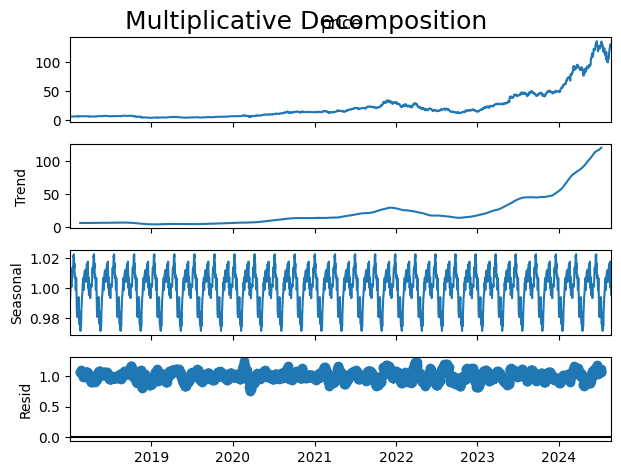

In [3]:
decomposition_results = seasonal_decompose(df.price,model='multiplicative',period=90)
decomposition_results.plot().suptitle('Multiplicative Decomposition',
fontsize=18)


In [4]:
df=df.reset_index()

In [5]:
df=df.rename(columns={'Date': 'ds', 'price': 'y'})

In [6]:
print(df)

             ds           y
0    2018-01-02    4.930643
1    2018-01-03    5.255147
2    2018-01-04    5.282849
3    2018-01-05    5.327617
4    2018-01-06    5.327617
...         ...         ...
2421 2024-08-19  130.000000
2422 2024-08-20  127.250000
2423 2024-08-21  128.500000
2424 2024-08-22  123.739998
2425 2024-08-23  129.369995

[2426 rows x 2 columns]


In [69]:
train_indices = df['ds'] < pd.Timestamp('2024-08-21')

In [70]:
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index()

In [71]:
model_prophet = Prophet(seasonality_mode='multiplicative')
model_prophet.add_seasonality(name='daily', period=90,
fourier_order=5)

In [72]:
model_prophet.fit(df_train)

11:54:03 - cmdstanpy - INFO - Chain [1] start processing
11:54:04 - cmdstanpy - INFO - Chain [1] done processing


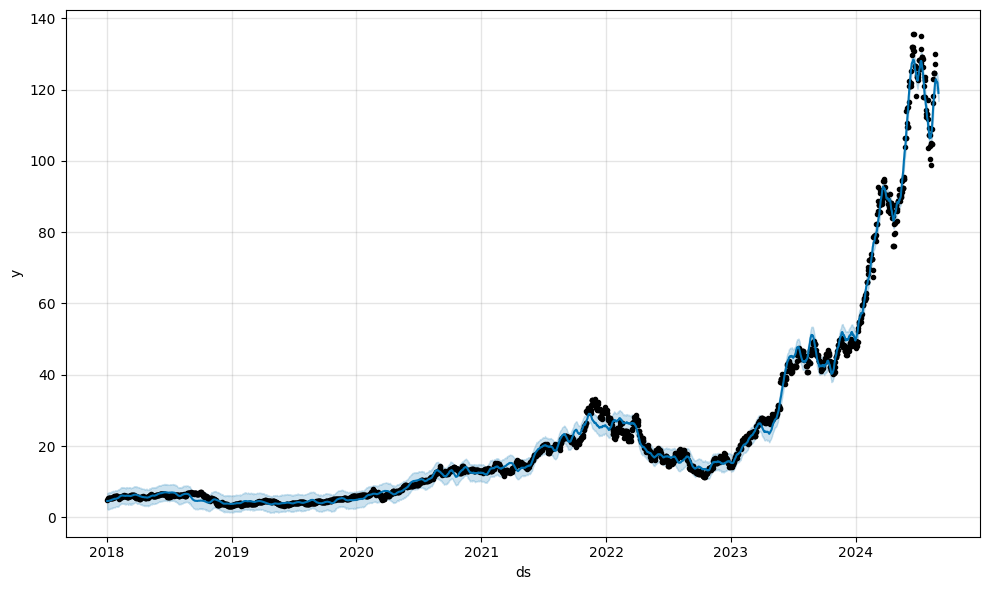

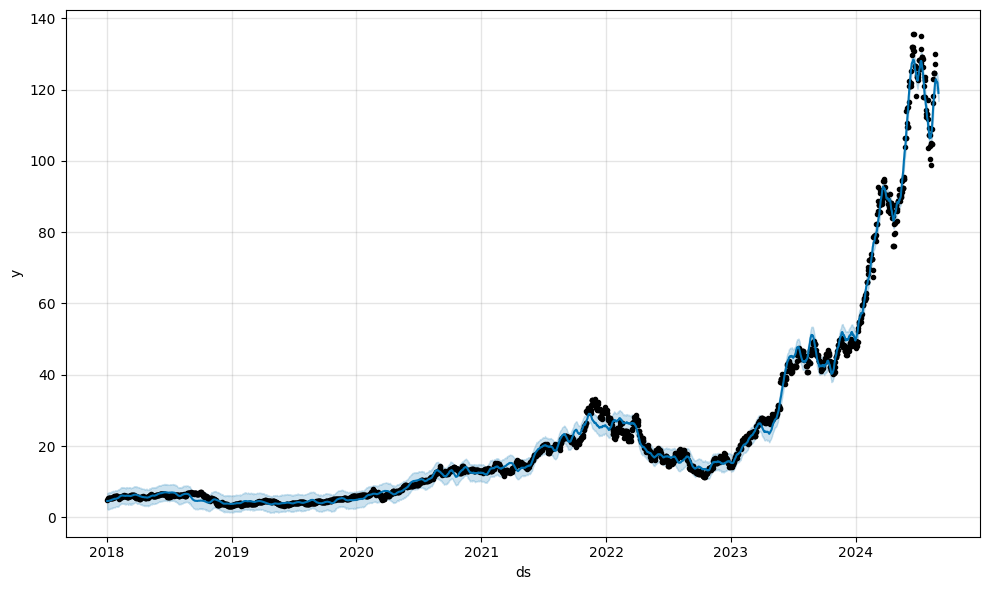

In [73]:
df_future = model_prophet.make_future_dataframe(periods=10)
df_pred = model_prophet.predict(df_future)
model_prophet.plot(df_pred)

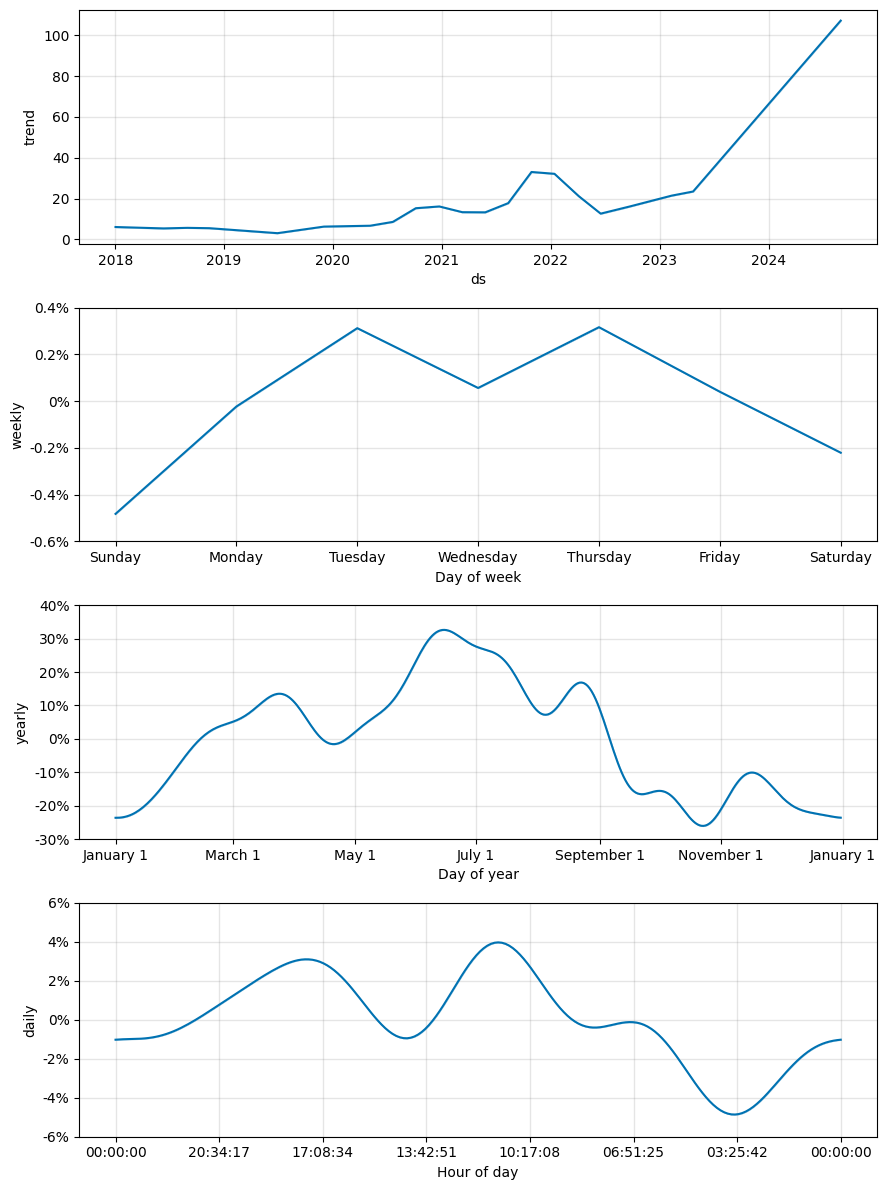

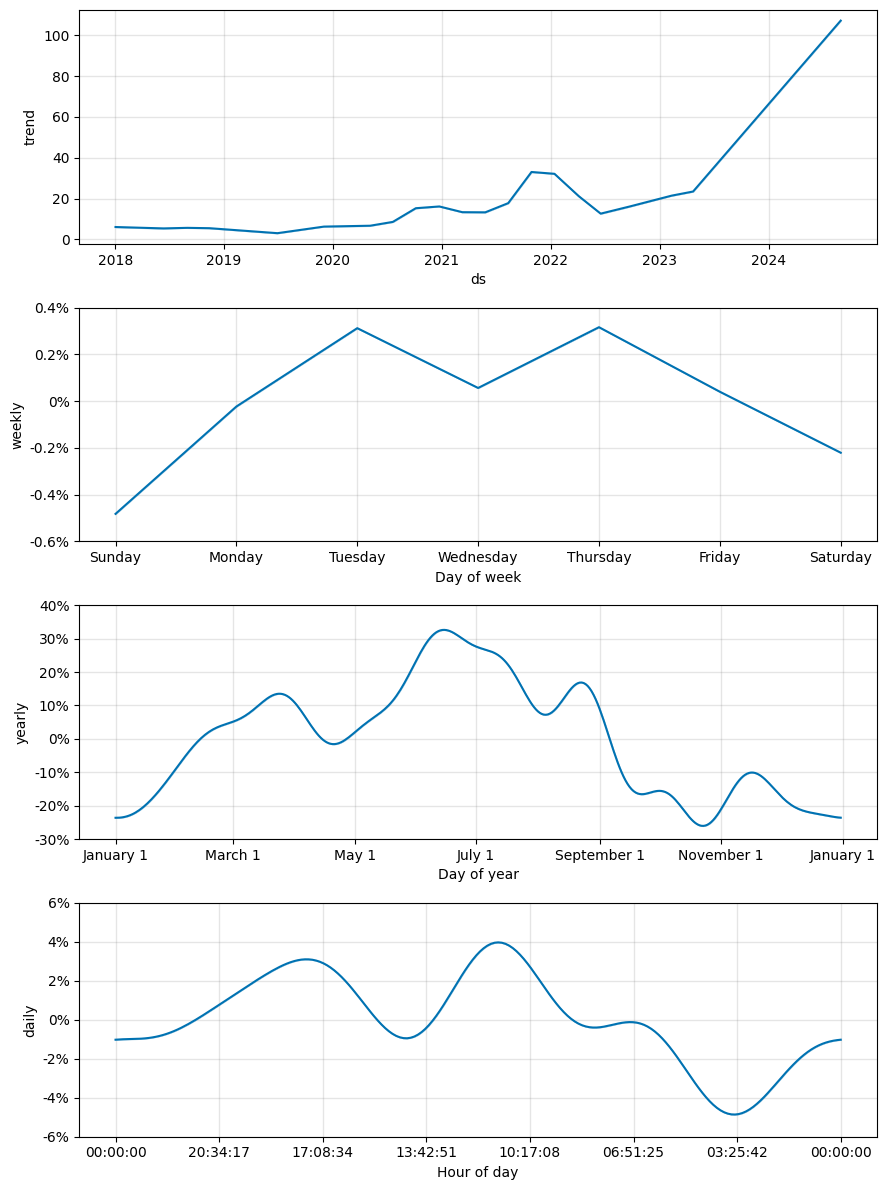

In [74]:
model_prophet.plot_components(df_pred)

In [75]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']
df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)
df_test = df_test.merge(df_pred, on=['ds'], how='left')
df_test.ds = pd.to_datetime(df_test.ds)
df_test.set_index('ds', inplace=True)

[Text(0.5, 1.0, 'Price - actual vs. predicted'), Text(0.5, 0, 'Date')]

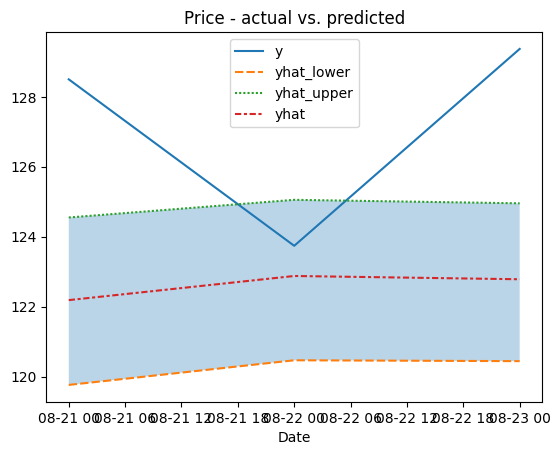

In [76]:
fig, ax = plt.subplots(1, 1)
ax = sns.lineplot(data=df_test[['y', 'yhat_lower', 'yhat_upper',
'yhat']])
ax.fill_between(df_test.index,
df_test.yhat_lower,
df_test.yhat_upper,
alpha=0.3)
ax.set(title='Price - actual vs. predicted',
xlabel='Date')

In [77]:
df_test

,index,y,yhat_lower,yhat_upper,yhat
ds,,,,,
2024-08-21,2423,128.500000,119.761847,124.549417,122.186927
2024-08-22,2424,123.739998,120.466564,125.054522,122.877059
2024-08-23,2425,129.369995,120.441725,124.954485,122.783202


In [78]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [79]:
def adf_test(x):
    indices = ['Test Statistic', 'p-value',
    '# of Lags Used', '# of Observations Used']
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    return results
adf_test(df.y)

Test Statistic               2.655354
p-value                      0.999083
# of Lags Used              26.000000
# of Observations Used    2399.000000
Critical Value (1%)         -3.433079
Critical Value (5%)         -2.862746
Critical Value (10%)        -2.567412
dtype: float64

In [80]:
df

,ds,y
0,2018-01-02,4.930643
1,2018-01-03,5.255147
2,2018-01-04,5.282849
3,2018-01-05,5.327617
4,2018-01-06,5.327617
...,...,...
2421,2024-08-19,130.000000
2422,2024-08-20,127.250000
2423,2024-08-21,128.500000
2424,2024-08-22,123.739998
